In [22]:
pip install -U huggingface-hub transformers


  Using cached huggingface_hub-1.0.0rc6-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-1.0.0rc6-py3-none-any.whl (502 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trackio 0.7.0 requires huggingface-hub<1.0.0, but you have huggingface-hub 1.0.0rc6 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: /home/FASTLAB2/.venvs/py312/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install trackio

  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.5/872.5 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 1.5 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 2.3 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 1.3 MB/s eta 0:00:00a 0:00:01
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 1.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc6
    Uninstalling huggingface-hub-1.0.0rc6:
      Successfully uninstalled huggingface-hub-1

In [12]:
from huggingface_hub import notebook_login

notebook_login()

Token has not been saved to git credential helper.


In [14]:
import trackio
trackio.init(project="my-project", space_id="mariyamsiddiqui/trackio")

* Created new run: mariyamsiddiqui-1761555702


In [15]:
for i in range(10):
    trackio.log({"loss": 1/(i+1)})

In [16]:
trackio.finish()

* Run finished. Uploading logs to Trackio (please wait...)


In [17]:
#Loading Dataset

from datasets import load_dataset

dataset = load_dataset("merve/doclaynet-small")['test']
dataset = dataset.train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

README.md: 0.00B [00:00, ?B/s]

data/test-00000-of-00003.parquet:   0%|          | 0.00/390M [00:00<?, ?B/s]

data/test-00001-of-00003.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00002-of-00003.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [18]:
#Exploring Dataset (generic function you can use to explore the dataset)

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_cells(img, pdf_cells, min_side=1.0):
    W, H = img.size

    cells = []
    if pdf_cells and isinstance(pdf_cells[0], list):
        for group in pdf_cells:
          cells.extend(group)
    else:
        cells = pdf_cells or []

    def clip_xywh(x, y, w, h):
        x1, y1, x2, y2 = x, y, x + w, y + h
        if x2 <= 0 or y2 <= 0 or x1 >= W or y1 >= H:
            return None

        x1 = max(0.0, x1)
        y1 = max(0.0, y1)
        x2 = min(W, x2)
        y2 = min(H, y2)

        if x2 - x1 < min_side or y2 - y1 < min_side:
            return None
        return x1, y1, x2 - x1, y2 - y1

    fig, ax = plt.subplots(figsize=(10, 12))
    ax.imshow(img)
    ax.set_xlim(0, W)
    ax.set_ylim(H, 0)
    for cell in cells:
        x, y, w, h = cell["bbox"]
        clipped = clip_xywh(x, y, w, h)
        if clipped is None:
            continue
        cx, cy, cw, ch = clipped
        ax.add_patch(Rectangle((cx, cy), cw, ch, fill=False, linewidth=1.5))

        ax.text(cx + 10, cy + 20, cell["text"], fontsize=8, va="center_baseline", color="red")

    plt.tight_layout(); plt.show()
    plt.close(fig)

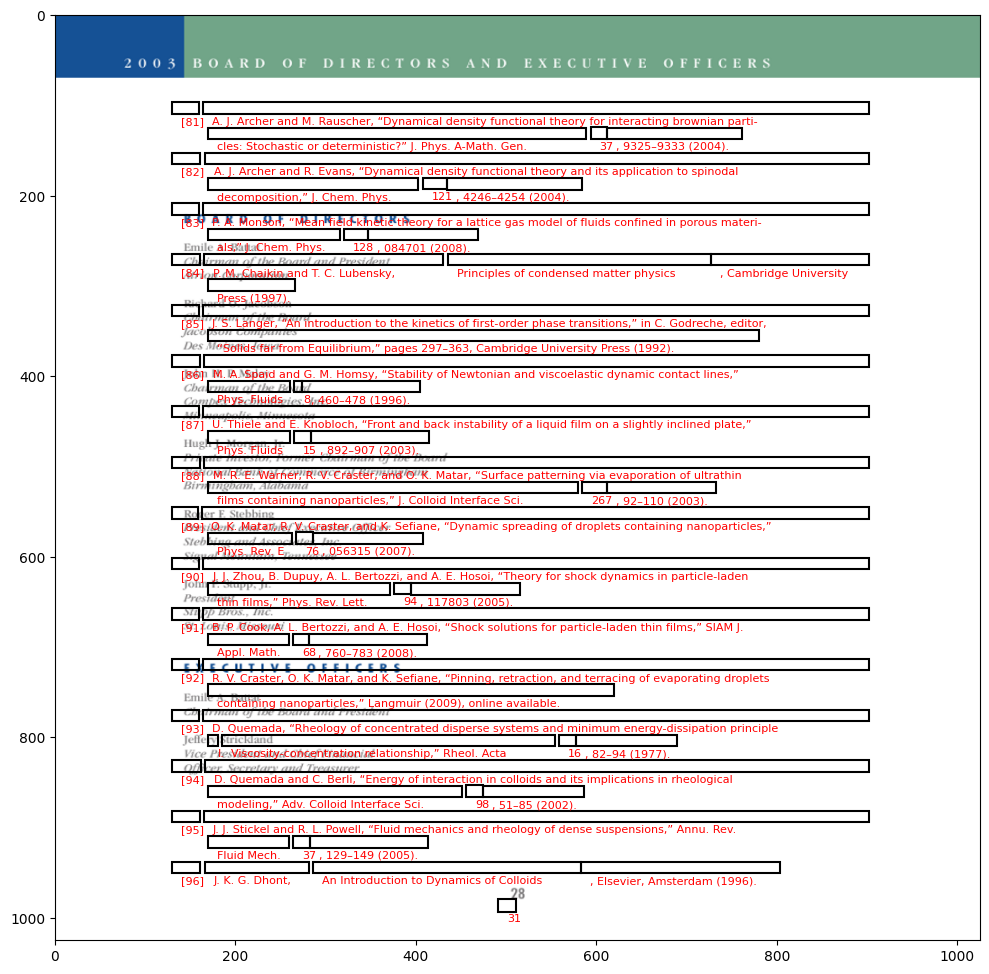

In [19]:
from PIL import Image

img = train_ds[99]["image"]
W, H = img.size

visualize_cells(img, train_ds[30]["pdf_cells"], min_side=1)

In [23]:
# Let's load the model and the processor

from transformers import AutoProcessor, Kosmos2_5ForConditionalGeneration
import torch

model = Kosmos2_5ForConditionalGeneration.from_pretrained("microsoft/kosmos-2.5", device_map="cuda", dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2.5")

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

Kosmos2_5TextForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/178 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

The OrderedVocab you are attempting to save contains holes for indices [100260, 100265, 100266, 100267, 100268, 100269, 100270, 100271, 100272, 100273, 100274, 100275, 100276, 100277, 100278, 100279, 100281], your vocabulary could be corrupted !


In [28]:
def preprocess_batch(pdf_cells_list, img_sizes, target_sizes):
    """
    Convert OCR cell data into <bbox>text format expected by Kosmos-2.5.
    Each pdf_cells item should be a list of dicts with 'bbox' and 'text'.
    """
    processed_targets = []

    for cells, img_size, target_size in zip(pdf_cells_list, img_sizes, target_sizes):
        width_ratio = target_size[0] / img_size[0]
        height_ratio = target_size[1] / img_size[1]

        text_with_bboxes = ""

        for cell in cells:
            if "bbox" not in cell or "text" not in cell:
                continue  # skip invalid entries

            x1, y1, x2, y2 = cell["bbox"]
            # Scale coordinates to resized image dimensions
            x1, y1 = int(x1 * width_ratio), int(y1 * height_ratio)
            x2, y2 = int(x2 * width_ratio), int(y2 * height_ratio)

            text = cell["text"].strip().replace("\n", " ")
            text_with_bboxes += f"<bbox><x_{x1}><y_{y1}><x_{x2}><y_{y2}></bbox>{text} "

        processed_targets.append(text_with_bboxes.strip())

    return processed_targets


def collate_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]
    pdf_cells_list = [example["pdf_cells"] for example in examples]
    img_sizes = [img.size for img in images]

    target_sizes = []
    for img in images:
        inp = processor(images=img, return_tensors="pt")
        target_sizes.append((int(inp["width"]), int(inp["height"])))

    targets = preprocess_batch(pdf_cells_list, img_sizes, target_sizes)

    PROMPT = "<ocr>"
    full_texts = [PROMPT + t for t in targets]

    inputs = processor(text=full_texts, images=images, return_tensors="pt", padding=True, truncation=True)

    labels = inputs["input_ids"].clone()

    prompt_ids_batch = processor.tokenizer([PROMPT] * len(full_texts), add_special_tokens=True).input_ids

    # mask input part
    for idx, prompt_ids in enumerate(prompt_ids_batch):
        labels[idx, :len(prompt_ids)] = -100

    inputs["labels"] = labels
    return inputs


In [29]:
#We can now setup the trainer

from transformers import TrainingArguments
args=TrainingArguments(
            num_train_epochs=2,
            remove_unused_columns=False,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=2,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            learning_rate=2e-5,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="adamw_torch",
            save_strategy="steps",
            save_steps=1000,
            save_total_limit=1,
            output_dir="kosmos2_5",
            bf16=True,
            report_to=["trackio"],
            dataloader_pin_memory=False,
            push_to_hub=True
        )

In [30]:
from transformers import Trainer

trainer = Trainer(
        model=model,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn,
        args=args
        )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [31]:
# Kick-off the training

trainer.train()

* Created new run: mariyamsiddiqui-1761556589


Step,Training Loss
100,0.405600
200,0.000600
300,0.000100
400,0.000100
500,0.000100
600,0.000100
700,0.000100
800,0.000100
900,0.000100
1000,0.000100


* Run finished. Uploading logs to Trackio (please wait...)


TrainOutput(global_step=1126, training_loss=0.03612546470741201, metrics={'train_runtime': 4205.9344, 'train_samples_per_second': 1.07, 'train_steps_per_second': 0.268, 'total_flos': 6.6231796082688e+16, 'train_loss': 0.03612546470741201, 'epoch': 2.0})

In [32]:
from transformers import AutoProcessor, Kosmos2_5ForConditionalGeneration
import torch

model = Kosmos2_5ForConditionalGeneration.from_pretrained("merve/kosmos-2.5-ft", device_map="cuda", dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2.5")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Kosmos2_5TextForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

The OrderedVocab you are attempting to save contains holes for indices [100260, 100265, 100266, 100267, 100268, 100269, 100270, 100271, 100272, 100273, 100274, 100275, 100276, 100277, 100278, 100279, 100281], your vocabulary could be corrupted !


In [33]:
import re

image = test_ds[0]["image"]
prompt = "<ocr>"
inputs = processor(text=prompt, images=image, return_tensors="pt")
height, width = inputs.pop("height"), inputs.pop("width")
raw_width, raw_height = image.size
scale_height = raw_height / height
scale_width = raw_width / width

inputs = {k: v.to("cuda") if v is not None else None for k, v in inputs.items()}
inputs["flattened_patches"] = inputs["flattened_patches"].to(torch.bfloat16)

In [34]:
generated_ids = model.generate(
    **inputs,
    max_new_tokens=2000,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [36]:
image = test_ds[0]["image"]

In [37]:
import re
from PIL import ImageDraw

def post_process(y, scale_height, scale_width):

    pattern = r"<bbox><x_\d+><y_\d+><x_\d+><y_\d+></bbox>"
    bboxes_raw = re.findall(pattern, y)
    lines = re.split(pattern, y)[1:]
    bboxes = [list(map(int, re.findall(r"\d+", bb))) for bb in bboxes_raw]

    out_lines = []
    for i, box in enumerate(bboxes):
        if len(box) != 4:
            continue
        x0, y0, x1, y1 = box

        if x0 >= x1 or y0 >= y1:
            continue

        sx0 = int(x0 * scale_width)
        sy0 = int(y0 * scale_height)
        sx1 = int(x1 * scale_width)
        sy1 = int(y1 * scale_height)

        label = lines[i] if i < len(lines) else ""
        label = label.lstrip(", ").strip()

        out_lines.append(f"{sx0},{sy0},{sx1},{sy0},{sx1},{sy1},{sx0},{sy1},{label}")

    return "\n".join(out_lines)


output_text = post_process(generated_text[0], scale_height, scale_width)
print(output_text)

draw = ImageDraw.Draw(image)

for line in output_text.strip().splitlines():
    coords = re.findall(r"-?\d+", line)[:8]
    if len(coords) < 8:
        continue
    xy = list(map(int, coords))
    draw.polygon(xy, outline="red")

image.save("output.png")

82,48,366,48,366,61,82,61,Consolidated Balance Sheets
82,79,198,79,198,88,82,88,As of December 31,
82,94,277,94,277,103,82,103,(In millions, except for share data)
739,94,769,94,769,103,739,103,2001
930,94,960,94,960,103,930,103,2000
82,112,131,112,131,123,82,123,Assets
82,128,168,128,168,139,82,139,Investments
82,145,426,145,426,156,82,156,Fixed maturities, available for sale, at fair value
95,162,380,162,380,172,95,172,(amortized cost of $39,154 and $33,856)
701,162,710,162,710,172,701,172,$
724,162,769,162,769,172,724,172,40,046
892,162,901,162,901,172,892,172,$
914,162,960,162,960,172,914,172,34,492
82,181,601,181,601,191,82,191,Equity securities, available for sale, at fair value (cost of $1,289 and $921)
732,181,769,181,769,191,732,191,1,349
922,181,960,181,960,191,922,191,1,056
82,200,338,200,338,210,82,210,Policy loans, at outstanding balance
732,200,769,200,769,210,732,210,3,317
922,200,960,200,960,210,922,210,3,610
82,219,213,219,213,229,82,229,Other investments
732,219,769,2

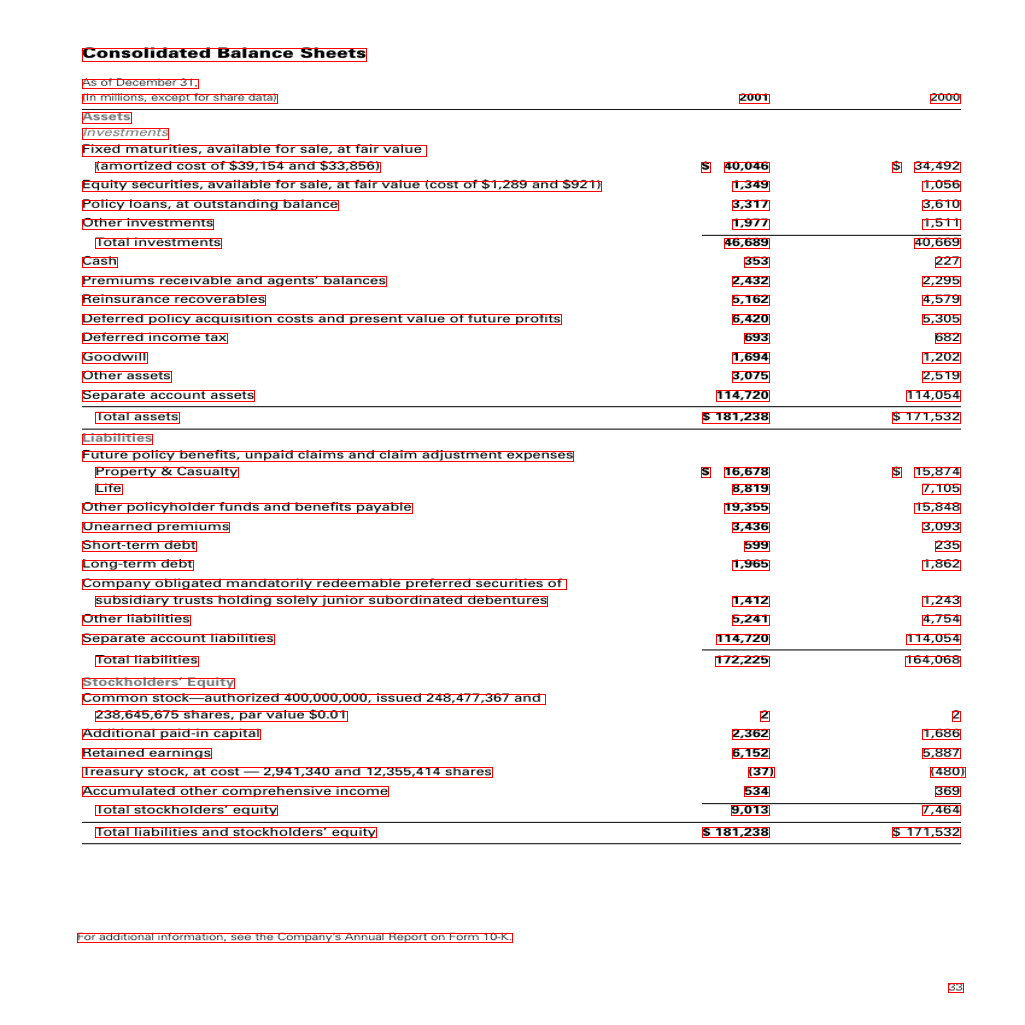

In [38]:
display(image)